Digital Signal Processing Courseware: An Introduction (copyright © 2024)
## Authors: J. Christopher Edgar and Gregory A. Miller

Originally written in Mathematica by J. Christopher Edgar. Conversion to Jupyter Notebook by Song Liu.

The authors of this courseware are indebted to Prof. Bruce Carpenter (University of Illinois Urbana-Champaign). Bruce inspired the creation of this courseware, he consulted with the authors as this courseware was being developed, and he provided the original version of the code and text for several sections of this courseware (e.g. the section on complex numbers and the section on normal distributions). 


# <font color=red>DSP.02 Sampling Rate and Aliasing</font>
# <font color=red>BASICS</font>

In Lesson 1, we examined some basic properties of time-domain and spatial-domain data. In Lesson
2, we'll discuss sampling rates, and we'll examine one of the most important theorems associated with
temporal and spatial data - the Nyquist-Shannon Theorem. After completing Lesson 2, you'll be able
to determine how often you need to collect data samples in your own experiments. You'll also be able
to identify what errors are likely to appear in your data if the assumptions of the Nyquist-Shannon Theorem are
violated.

### Setup

In [1]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image as img
from matplotlib import cm
from mpl_toolkits import mplot3d
from scipy.fft import fft, fftfreq
import matplotlib.patches as patches
import math
import cmath
import pandas as pd
from sympy import Symbol, sin, series
from sympy import roots, solve_poly_system
import scipy.special

import warnings
warnings.filterwarnings('ignore')

# Figure size 
plt.rc("figure", figsize=(8, 6))

#function to create time course figure
#one waveform
def make_plot_1(x1,y1,type="b",linewidth = 1): 
    plt.plot(x1, y1,type)
    plt.margins(x=0, y=0)
    plt.axhline(y=0, color='k')
    plt.tick_params(labelbottom = False, bottom = False)
    
#two overlaid waveforms with red and blue   
def make_plot_2(x1,y1,type1,x2,y2,type2): 
    plt.plot(x1, y1, type1)
    plt.plot(x2, y2, type2)
    plt.margins(x=0, y=0)
    plt.axhline(y=0, color='k')
    plt.tick_params(labelbottom = False, bottom = False)
    
#three overlaid waveforms with red, blue and green   
def make_plot_3(x1,y1,type1,x2,y2,type2,x3,y3,type3): 
    plt.plot(x1, y1, type1)
    plt.plot(x2, y2, type2)
    plt.plot(x3, y3, type3)
    plt.margins(x=0, y=0)
    plt.axhline(y=0, color='k')
    plt.tick_params(labelbottom = False, bottom = False)
    
def make_plot_3d(ax,x,y,z):    
    ax.contour3D(x, y, z, 50, cmap=cm.coolwarm)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
def make_plot_freq_1(x1,sample_rate, duration=1): 
    N = sample_rate * duration
    Nhalf = math.ceil(N/2)
    yf = fft(x1)
    xf = fftfreq(N, 1 / sample_rate)
    yf = yf[0:Nhalf]
    xf = xf[0:Nhalf]
    plt.plot(xf, np.abs(yf))
    
#two spectrums
def make_plot_freq_2(x1,x2,sample_rate, duration=1): 
    N = sample_rate * duration
    Nhalf = math.ceil(N/2)
    yf1 = fft(x1)
    yf2 = fft(x2)
    xf = fftfreq(N, 1 / sample_rate)

    yf1 = yf1[0:Nhalf]
    yf2 = yf2[0:Nhalf]
    xf = xf[0:Nhalf]

    plt.plot(xf, np.abs(yf1))
    plt.plot(xf, np.abs(yf2), color = 'r')
    
def make_imshow(x):
    plt.imshow(x,cmap='Greys_r')
    plt.tick_params(labelbottom = False, bottom = False)
    plt.tick_params(labelleft = False, left = False)
    
def make_imshow_color(x):
    plt.imshow(x)
    plt.tick_params(labelbottom = False, bottom = False)
    plt.tick_params(labelleft = False, left = False)
    
def round_complex(x):
    return complex(np.round(x.real,4),np.round(x.imag,4))

## <font color=red>DSP.02.B1) Sampling Data</font>

### <font color=red>DSP.02.B1.a) Values in a timeseries</font>

Plot a 1 Hz sine wave timeseries.

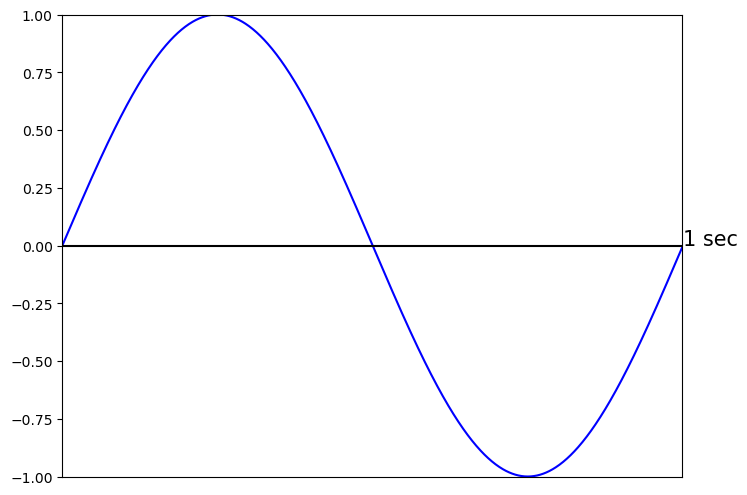

In [2]:
time = np.arange(0,1,0.001) #create an array representing 1 second
freq = 1
timeseries = np.sin(2*np.pi * freq * time) # sin(2𝜋 * 1 * time)

make_plot_1(time,timeseries)
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

This plots a 1 Hz sine wave - 1 cycle/second. By inputting a specific value (in seconds) into the
function 'sin[1x×2π]' we can calculate the y-axis amplitude of this function at any time point. (You probably 
remember from Lesson 1 that sine functions can be used to describe functions over distance or in space, not just over
time. Here we'll refer to time for simplicity, but the things we say here about sine waves over
time are also true for sine waves over distance.)

Here are a few values (speed through creating the 3 values, then we'll comment on them):


In [3]:
y_length = len(timeseries)
round(timeseries[y_length-1],1)

-0.0

In [4]:
round(timeseries[round(0.25*(y_length-1))],1)

1.0

In [5]:
round(timeseries[round(0.75*(y_length-1))],1)

-1.0

What are those 3 values? The first one takes us to the end of the 1-second vector we made containing a 1 Hz timeseries, stored in 'timeseries'. After 1 second of a 1 Hz timeseries that started at amplitude 0, we've completed a full cycle, so we're back at zero. (Don't worry about the rounded value being reported as '-0.0' rather than '0.0' - same thing.)

What about the other 2 values? By inserting 0.25 or 0.75, we moved through just the first 1/4 or first 3/4 of the 1 Hz cycle. So, we're at the postive peak = 𝜋/2 or the negative peak = 3𝜋/4.

In an experiment, we often collect data on phenomena that occur over time, for example measuring the
local temperature once every hour, or collecting measures of brain electrical activity over several
minutes. Once collected, we can plot the data as a function of time. (Or we could collect temperature
data at the same time in different locations, say north to south, and plot the data as a function of
location or distance.)

Any parameter that can be recorded repeatedly over time or space, if the change in time or space is
constant, can be treated as a vector of observations of the form: $X_{t}$ , $X_{t-d}$, $X_{t-2d}$, $X_{t-3d}$, ,...., $X_{t-nd}$.

If these values are recorded over time, the data are called a timeseries. The subscripts refer to the
time at which the value of the variable X is observed, with t being the time at which recording began and d being the sampling
period (the temporal distance between adjacent samples - a constant in most applications, and
assumed constant in the present discussion). The number of samples collected during a 1 unit period is
the sampling rate. If that 1 unit period is 1 second, the sampling rate is
also referred to as Hertz (Hz), such as 250 samples/sec = 250 Hz.


Don't confuse the Hz at which you are sampling with the Hz of the phenomenon you are sampling! Both
of these are talked about in terms of Hz, but their values are usually quite different, for reasons we will
explore shortly. So, we have the Hz of the phenomenon, and we have the Hz of the sampling (measurement)
process.

Another point about the phenomenon you're measuring vs. your measurement of it: most of the time, the original
phenomenon is a continuous function. But the kind of measurement we're interested in here can't be
done continuously. Our samples are discrete. For example, a room always has a temperature. It may
vary over time, but no matter how often you measure it, there is some temperature available. A traditional
mercury thermometer will measure the room's temperature continuously, too. But you can't
continuously write down the number the thermometer shows. You read the thermometer, and you
write down the reading. You can do that often, but you can't do it infinitely often. There is some time
between the readings you write down (the sample period). In this example, the temperature of the
room is a continuous function, whereas your written record of the temperature of the room is discrete. 

A so-called analog signal can take any value in a range, and it changes smoothly (continuously) between values. Thus, an analog signal is any signal continuous in both time and amplitude. Analog signals are often thought of in an electrical context. For example, in an analog sound recording, the variation in air pressure of a sound striking a microphone could create a corresponding variation in the electrical current passing through a circuit in the microphone, and that current is sent on to an amplifier and a recording device, such as a traditional tape recorder. That variation happens on a continuous basis. The recorded signal is continuous and is an "analog" of the original, real-world phenomenon.

A digital signal, on the other hand, is characterized by discrete values rather than a continuous function of (usually varying) values. Early digital systems that were used to communicate across long distances include smoke signals (puffs convey information - not just a continuous column of smoke, which would be analog) and Morse code (dots, dashes, and gaps convey information).

Some phenomena we want to measure are inherently analog (continuous), and some are inherently digital (discrete). We can design electrical circuits that are optimized for processing either analog or digital signals. There are analog computers, which can handle analog (continuous) signals. But a digital computer can only handle digital (discrete) values. How can we use a digital computer to process analog signals?

Answer: we can sample the analog signal from time to time, with each sample being a single number - a discrete value (typically a voltage). And we can store a series of such samples in a vector, in our computer's memory (in RAM, on disk, whatever), then do turn our digital computer loose to crunch the data. For that to happen, we use a circuit called an analog-to-digital converter (A/D converter, sometimes just ADC). There's an A/D converter in an MRI scanner, digitizing what the receiver coil picks up. If you plug a ribbon cable from an EEG cap into a box that sends the EEG on to your lab computer, typically these days that box contains an A/D converter that samples each channel and sends a series of values to your computer via a USB connection. In older equipment, the A/D converter will be on a card inserted into the computer. One way or another, we convert analog (continuous) to digital (discrete) signals so that our digital computer can handle the data.

This e-book on digital signal processing doesn't discuss how A/D converters work. Suffice to say that signal processing on digital computers is necessarily DIGITAL signal processing and that a lot of that is done on signals that were originally analog and were digitzed with A/D converters. Lesson 2 is interested in the rate of that sampling - how often the A/D conversion happens for a given signal.

So... In the examples provided in this digital signal processing e-book, the external phenomena that we represent via our time (or distance/space) series are considered to be analog events - they are continuous across time and/or space. Thus, a bird's song (analog) is continuous (physical disturbances in air). Our digitized recording of the bird's song, however, contains discrete values and is ... digital. Ditto recordings of magnetic resonance, EEG, MEG, EKG, EMG, electrodermal, eye-position activity.

In case you're wondering: modern cell phone communicate with inherently digital signals. Early cell phones used analog signals. Ditto modern vs. earlier broadcast TV signals.

Two important nitty-gritty point about the (digital) sampling of analog signals:

First, the Hz of the real-world phenomenon that you are sampling and the Hz of the sampling rate are completely different things and don't have any necessary relationship.

Second, don't confuse the sampling rate with the sampling period. They are the reciprocal (inverse) of each other. If your sampling rate is 4 Hz (4 times per second), then your sampling period is 1/4 second (250 msec). If you sample at 1000 Hz, your sampling period is 1/1000 = 1 msec. In this way, the sampling rate and the sampling period are locked together (as reciprocals).

OK, back to work. Run the code below to create a 10 Hz timeseries with the sampling rate is set at 100 Hz. A sampling
rate of 100 means we will collect 100 samples during a 1 second period. **To show all 10 periods of the 10 Hz timeseries, we need to get to the start of next second. So, to make a nice plot, we will collect 101 samples.** 

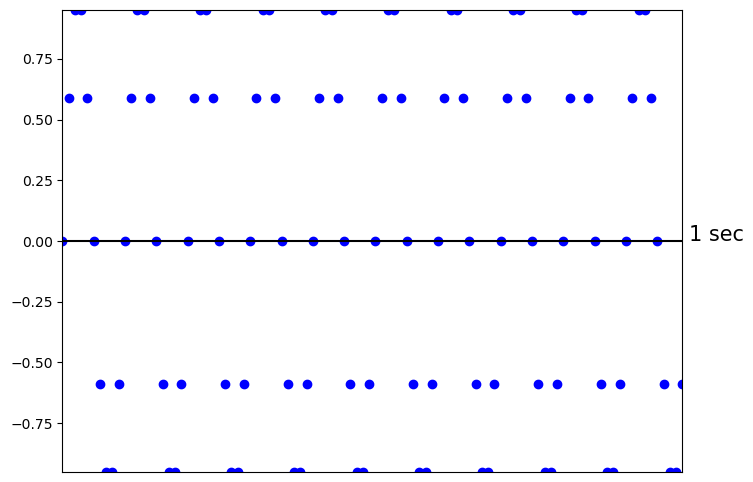

In [6]:
time = np.arange(0,1.0,0.01) #collecting 101 samples in a 1 second period
freq = 10
timeseries = np.sin(2*np.pi * freq * time) # sin(2𝜋 * 10 * time)

make_plot_1(time,timeseries,type='bo' )
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

The above plot looks odd, but it is a plot of the 101 datapoints collected across time. Now connect the dots.

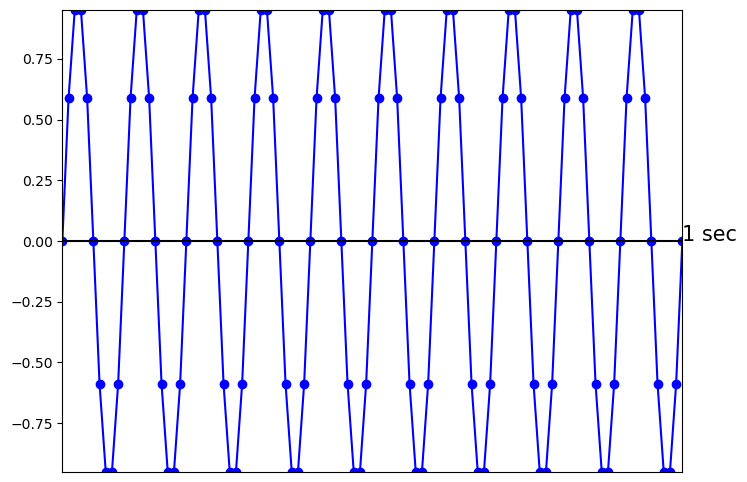

In [7]:
time = np.arange(0,1.01,0.01) #collecting 101 samples in a 1 second period
freq = 10
timeseries = np.sin(2*np.pi * freq * time) # sin(2𝜋 * 10 * time)

make_plot_1(time,timeseries,type='bo-' )
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

The original plot was valid as a representative of the hypothetical original (continuous) sine function, but this version is more pleasing to the eye. This time, 'make_plot_1' interpolated
values we did not record. In effect, we started with an analog (continuous) sine wave, we sampled it (digitized it) so that we have a series of digital (discrete) values in our 'timeseries' vector, then we interpolated a whole lot of intervening values so that the plot would look continuous.

The sampling period is the reciprocal of the sampling rate. If we know the duration of our epoch
(1 second) and the number of samples collected (100; although 101 used for plotting) we can calculate the sample period: Time/Length = 1/100.

In [8]:
sampleperiod = 1/100

sampleperiod

0.01

In this example, the sampling rate was set to 100 during a 1 second period, so the sampling period = .01
sec. Thus, a data sample is collected once every ten milliseconds - the sample period. You can see that
the sampling rate and the sampling period are reciprocals of each other. Usually you can think in terms
of one or the other, but be sure to keep track of which one you're using. ("Sampling rate" is the same as
"sample rate" or "digitization rate". "Sampling period" is the same as "sample period.")

## <font color=red>DSP.02.B2) Sampling Rate - The Nyquist-Shannon Theorem</font>

### <font color=red>DSP.02.B2.a) The Nyquist-Shannon Theorem</font>

Suppose you are a scientist measuring electrical activity from the brain. For each channel you want to record, how often should you collect a
measure of brain activity? Once a second? Every half millisecond? Every hour? What do you think?
(Scientists might ask 'What sampling or digitization rate should I use?').

Information travels through the brain very quickly. Scientists studying the brain often talk about brain processes that occur in time intervals as
short as a few milliseconds. Just think about that - 1000 milliseconds in a second and it takes only about 5 milliseconds for auditory
information to travel from the ear to the brain stem, and about 30 milliseconds for the information to reach primary auditory brain cortex
areas. We can take in quite a bit of auditory information in just 1 second. We better sample fast enough to represent the phenomena well.

Answer:
    
This question, about the appropriate sampling rate, requires a two-part answer. The Nyquist-Shannon
Sampling Theorem (also sometimes called just the Nyquist Theorem) provides the first half of the
answer. We'll cover that, then tackle the second half of the answer.

The Nyquist-Shannon Sampling Theorem:
    
For present purposes, the Nyquist-Shannon sampling theorem states that, for a timeseries to represent
a continuous waveform adequately, the sample rate (also called the sample frequency, fs, in samples per second) must be more than
twice the fastest frequency present in the original waveform. This requirement follows from a
principle: only if samples are obtained at least twice per cycle can a discrete timeseries accurately
represent the frequency of a sine wave. This principle is referred to as Nyquist's Rule. If you violate this principle, you'll risk distorting the original signal in how you represent it.

(Two caveats, then we'll get on with things. First, there's sometimes a way around this requirement, but we won't pursue that here. Second, you'll run across Nyquist's Rule stated as both that one must sample at least twice as fast and that one must sample more than twice as fast. Don't bother about that now. We'll get to the difference later. For now, more than twice is the safe choice.) 

There is a corollary
of this principle: since you have to sample more than twice as fast as the sine wave to represent it
accurately, you can turn that upside down and say that, given some sampling rate, the fastest sine
wave that your vector of samples can represent without distortion is one half of the sampling rate.

There is a name for that: one-half the sampling
frequency is referred to as the Nyquist Frequency. It's the fastest frequency in the phenomenon that
the sampling frequency can represent without distortion.

We'll investigate that distortion in a moment.
Let's examine the Nyquist-Shannon sampling theorem. (Again: it states that, for a timeseries to represent
a continuous waveform adequately, the sample rate (fs in samples per second) must be more than
twice the fastest frequency present in the original waveform.)

Suppose that the brain is producing varying electrical activity, with a frequency of 10 cycles per second
= 10 Hz. (Reminder: Don't confuse the frequency of the brain activity with the frequency at which we
will sample the brain activity! So far in this example, we've said what the frequency of the signal is. We haven't said anything about how fast we'll sample it. We're about to do that....) Let's say that we collect 1 second of
electrical activity from the brain with a sampling rate of 200 samples/second.

          
Run the Python code below to create a 10 Hz timeseries with the sampling rate is set at 200 Hz. A sampling
rate of 200 means we will collect 200 samples during a 1 second period. **To show all 10 periods of the 10 Hz timeseries, we need to get to the start of next second. So, to make a nice plot, we will collect 201 samples.** 

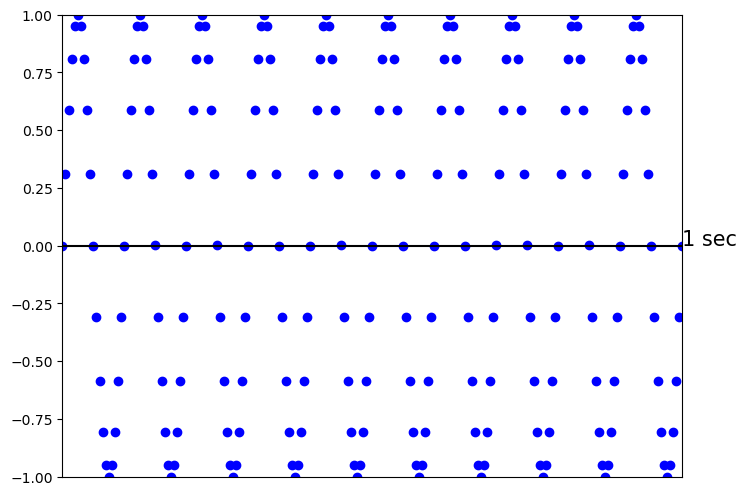

In [9]:
time = np.arange(0,1.005,0.005) #collecting 200 samples in a 1 second period
freq = 10
timeseries = np.sin(2*np.pi * freq * time)  # sin(2𝜋 * 10 * time)

make_plot_1(time,timeseries,type='bo' )
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

Now connect the dots.

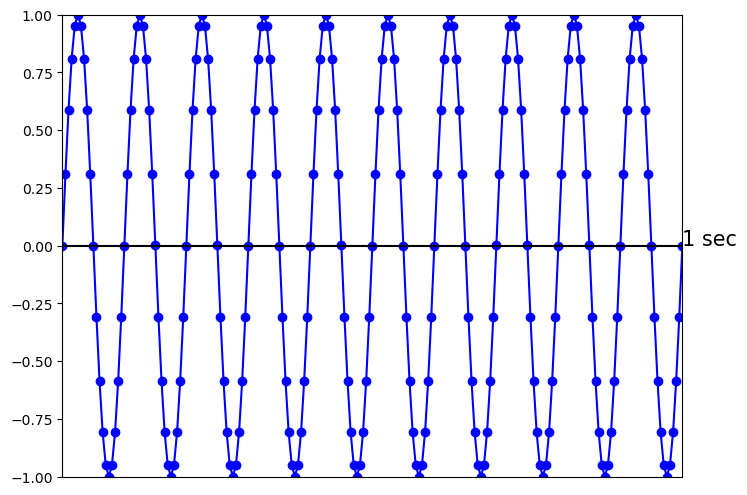

In [10]:
time = np.arange(0,1.005,0.005)
freq = 10
timeseries = np.sin(2*np.pi * freq * time)

make_plot_1(time,timeseries,type='bo-' )
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

The line plot is more pleasing to the eye.

With 'make_plot_1', we made the plot look as if our measures are continuous, but it's not true - we still
have just 200 datapoints - not an infinite number of them, with infinite density.

If we know the duration of our epoch (1 second) and the number of samples collected (200) we can
calculate the sample period: Time/Length = 1/200.

In [11]:
sampleperiod = 1/200

sampleperiod

0.005

That number has units of seconds. 0.005 seconds = 5 milliseconds. So, we collect a sample of brain activity once every 1/200 = 5 milliseconds. Are we sampling often enough
to get an accurate measure of brain activity?

Answer:
    
IT DEPENDS!

Remember, for a timeseries to accurately represent a continuous waveform, the sampling rate must be
more than twice the fastest frequency present in the original waveform. This is the Nyquist Rule. When
sampling at some sampling frequency fs, one can obtain reliable frequency information only for frequencies
less than fs/2 Hz.

Here are some examples:
    
-With a sampling frequency = 250 Hz, we can represent the information properly only for frequencies
less than 250/2 = 125 Hz.

-With a sampling frequency = 380 Hz, we can represent the information properly only for frequencies
less than 380/2 = 190 Hz.

-With a sampling frequency = 8 Hz, we can represent the information properly only for frequencies
less than 8/2 = 4 Hz.

The plot above is of a 10 Hz sine wave timeseries. To accurately represent the 10 Hz timeseries, we
need to set the sampling rate at more than 20 Hz. The sample rate above was 200 Hz, well above what is required by the Nyquist Rule. So, yes, we are
sampling fast enough to get an accurate measure of brain activity in this example.

## <font color=red>DSP.02.B3) Aliasing</font>

### <font color=red>DSP.02.B3.a) Sampling Below the Nyquist frequency</font>

We said a moment ago that, if we don't sample fast enough, the representation in our vector of samples will be a distorted version of the original phenomenon. Now let's look at the distortion that can
occur if we don't sample often enough. What happens when the sampling rate is not high enough?

Answer:

The answer is simple but not obvious, so let's develop it step by step. In normal English, the term 'alias'
refers to an alternative name, sometimes a misleading name. In the context of signal processing, 'alias' refers
to a mistaken frequency. If the Nyquist Rule is violated, the resulting digitized signal (in our vector of
samples) may contain frequency components not present in the original data. This phenomenon is
known as aliasing, because a component of the signal appears at a frequency in the sampled data different
from its frequency in the original signal. In particular, a frequency will appear in the vector of samples
that is lower than the frequency in the original phenomenon. Let's look at the effect of aliasing.

Start with a 10 Hz wave digitized at 100 Hz, providing a Nyquist Frequency of 100/2 = 50 Hz .
Remember that the Nyquist Frequency depends solely on the sampling frequency, not on the frequency
of what we're sampling. We're sampling at 100 Hz, so the Nyquist Frequency is
50 Hz, so our resulting timeseries can represent anything slower than 50 Hz without distortion.

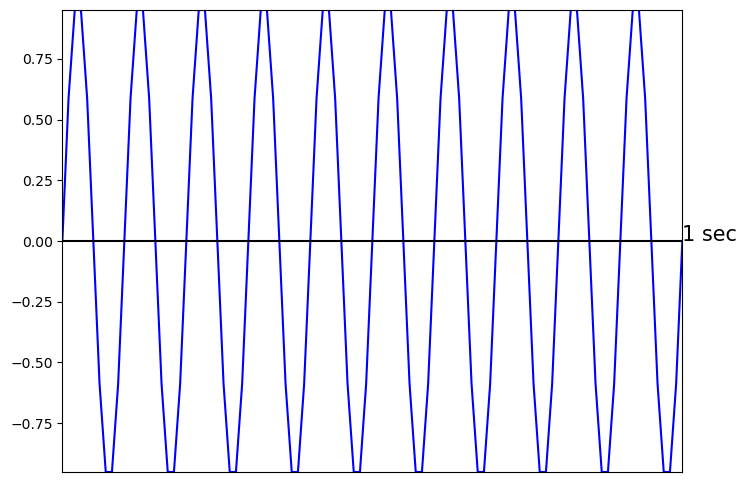

In [12]:
time = np.arange(0,1.01,0.01) #collecting 101 samples to make a nice plot
freq = 10
timeseries = np.sin(2*np.pi * freq * time) # sin(2𝜋 * 10 * time)

make_plot_1(time,timeseries)
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

For the 10 Hz signal, the 100 Hz sampling rate (a.k.a the digitization rate) does a good job of
representing the original, continuous waveform, seeming to lose just a bit at the peaks of the cycles.
We're sampling well above the Nyquist Frequency, so we are OK: remember that a 10 Hz signal requires that we sample
above 20 Hz, and 100 Hz sampling rate is well above that required 20 Hz.

To look at the same situation from a different perspective: the Nyquist Frequency of 50 Hz is well above the signal frequency of 10 Hz.

Again: the sampling frequency you choose determines the Nyquist Frequency, and you want that to be above the fastest frequency in the signal you're going to sample.

Having just sampled a 10 Hz signal digitized at 100 Hz, take a look at a 20 Hz wave digitized at 100 Hz. Are we still OK - is sampling at 100 Hz fast enough to avoid distorting a 20 Hz signal?

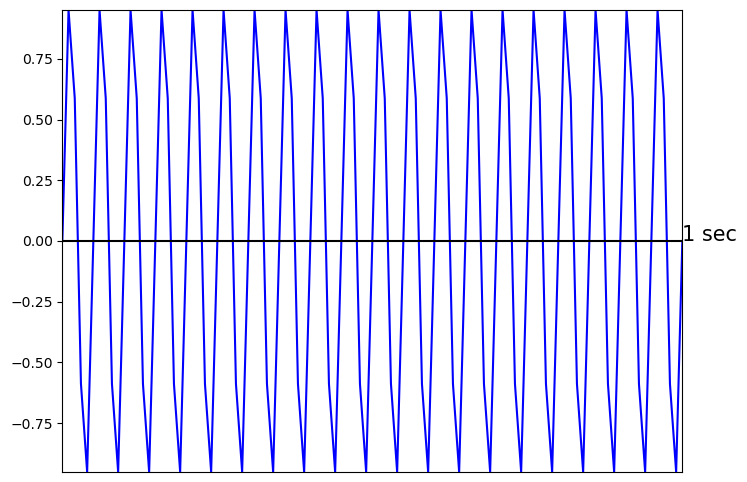

In [13]:
time = np.arange(0,1.01,0.01) #collecting 101 samples to make a nice plot
freq = 20
timeseries = np.sin(2*np.pi * freq * time)

make_plot_1(time,timeseries)
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

The 20 Hz signal is very recognizable, though the tracing is a bit choppy. Inspection verifies that 20
cycles are completed. Yes, we're still OK: our 100 Hz sampling rate provides a Nyquist Frequency of 100/2 = 50 Hz, well above the signal frequency of 20 Hz. So, no distortion. 

What about a 40 Hz wave digitized at 100 Hz?

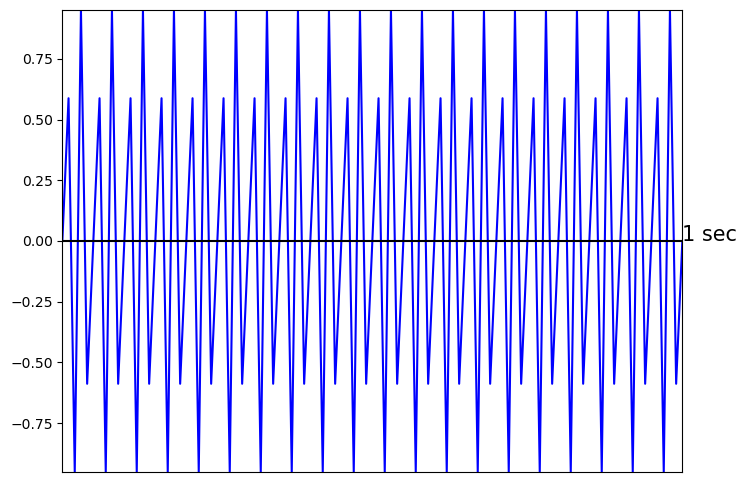

In [14]:
time = np.arange(0,1.01,0.01) #collecting 101 samples to make a nice plot
freq = 40
timeseries = np.sin(2*np.pi * freq * time)

make_plot_1(time,timeseries)
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

To the eye, the 40 Hz signal looks very choppy and perhaps composed of several frequencies. But,
because it is below the Nyquist Frequency of 50 Hz, it is still accurately represented - there are 40
downward peaks, even though not all at the same height. This illustrates that sampling at more than
twice the frequency in the signal does not ensure an attractive representation. So, for some purposes,
sampling faster than the Nyquist Frequency may not be satisfactory. All it may do is ensure that you're
not misrepresenting the frequency in the original phenomenon.

Not convinced that sampling a 40 Hz signal at 100 Hz is sufficient to represent the 40 Hz activity? Use
the code below to apply a Fourier transform and plot the frequency spectrum to examine the frequencies
making up this timeseries. We will look at the Fourier technique in detail in Lesson 6. This is just a
friendly introduction to the Fourier Transform.

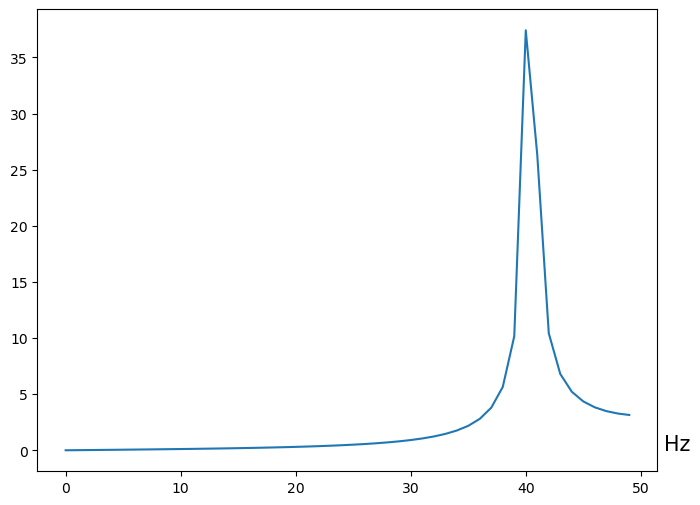

In [15]:
make_plot_freq_1(timeseries,100) #collecting 100 samples in a 1 second period

# Adding text to the figure
plt.text(52,0,'Hz',fontsize=15)
plt.show()

The Fourier transform takes a timeseries and outputs the frequencies in that timeseries. The x axis
plots frequency (not time), and the y axis is magnitude as a function of frequency. (This plot is sometimes
called a "frequency spectrum." After a few more lessons you'll be a pro at reading spectrum plots.) A
glance at the plot shows a peak at 40 Hz, indicating that, although the original plot isn't pretty, the
timeseries is still accurately represented. (You might wonder why it's not just a single, narrow spike
right at 40 Hz - why it spreads out a little around 40 Hz. Good question! The answer is again simple but
not obvious. Don't worry about that now - we'll discuss that in a later lesson.)

Now try a 60 Hz wave digitized at 100 Hz.

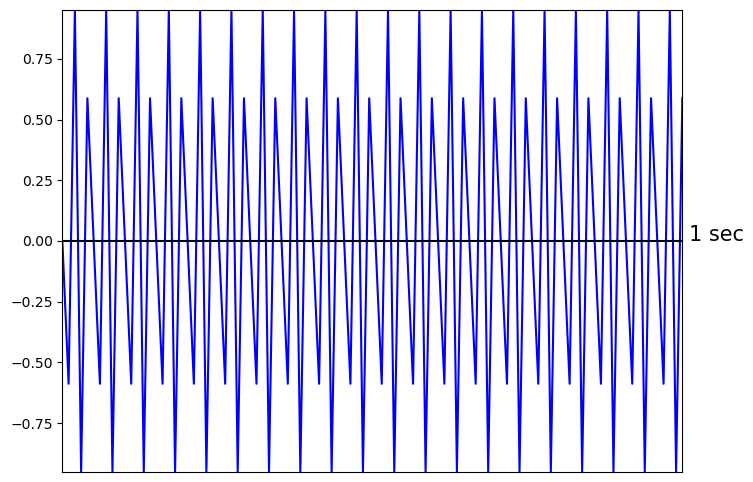

In [16]:
time = np.arange(0,1,0.01) #collecting 100 samples in a 1 second period
freq = 60
timeseries = np.sin(2*np.pi * freq * time)

make_plot_1(time,timeseries)
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

The 60 Hz signal is misrepresented in the plot, and not only to the eye. It appears to be almost identical
to the 40 Hz example above. In fact, it IS identical, except for a 180-degree phase reversal. (In other
words, it's simply flipped upside down.) Fourier frequency analysis would unambiguously (though
incorrectly) show that it is composed of a single, pure, 40 Hz component - not a 60 Hz component.

We say that the 60 Hz signal has been
'aliased' down to 40 Hz. Why? Because the Nyquist Frequency (50 Hz) resulting from our 100 Hz sampling
isn't at least (or preferably more than) twice as fast as the fastest frequency in the signal (60 Hz). Sampling at 100 Hz isn't adequate for capturing a 60 Hz signal.

Why does the 60 Hz signal
alias specifically to 40 Hz? This is because 60 and 40 are equidistant from the Nyquist frequency of 50 Hz.

Take a look at the frequency spectrum of our 60 Hz signal sampled at 100 Hz.

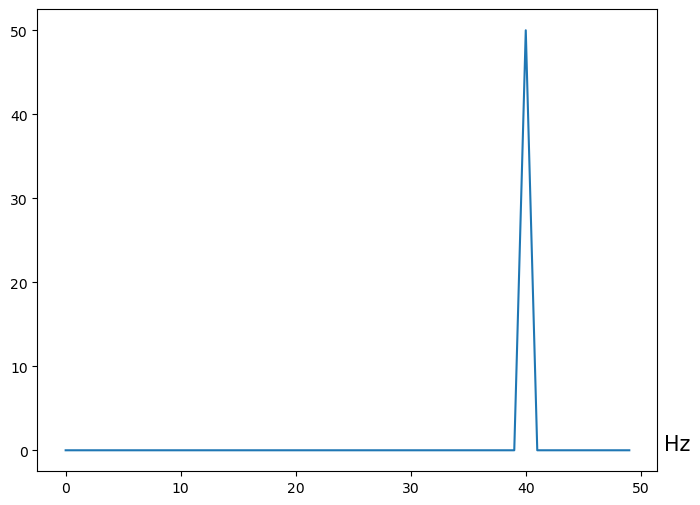

In [17]:
make_plot_freq_1(timeseries,100) #collecting 100 samples in a 1 second period

# Adding text to the figure
plt.text(52,0,'Hz',fontsize=15)
plt.show()

Just what we thought. The peak is at 40 Hz - not at 60 Hz, where it belongs. In a sense, there are 2 problems here. One problem is that the samples in our data vector don't represent 60 Hz activity accurately (they appear to represent a 40 Hz signal). The second problem is that our data vector doesn't LOOK
distorted - it looks like a perfectly good 40 Hz signal - very misleading. The 40 is the alias of the 60.

As a trickier example, what about a 97 Hz wave digitized at 100 Hz? If you didn't know about the
Nyquist-Shannon Theorem, you might think that, since 100 > 97, sampling a 97 Hz signal at 100 Hz
should work.

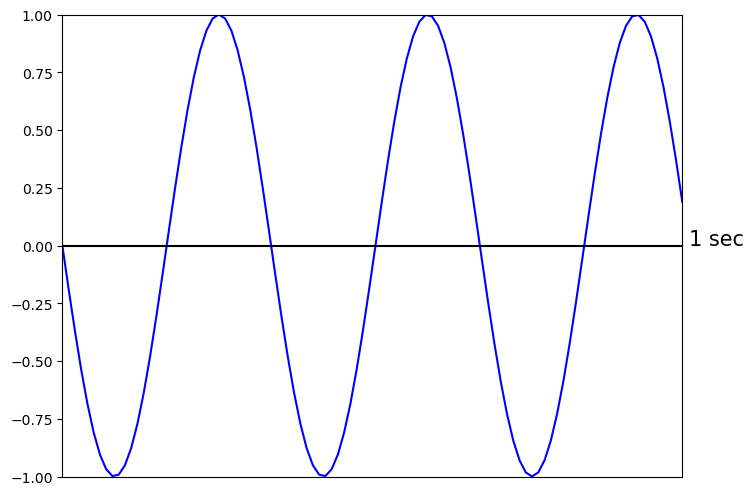

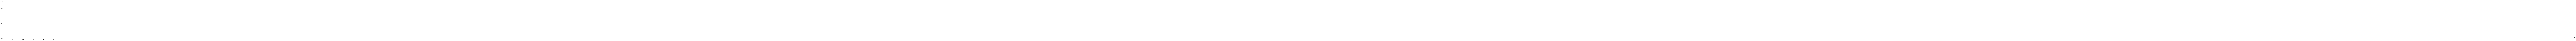

In [18]:
time = np.arange(0,1,0.01)
freq = 97
timeseries = np.sin(2*np.pi * freq * time)

make_plot_1(time,timeseries)
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

# Adding text to the figure
plt.text(52,0,'Hz')
plt.show()

The trace above shows an extreme and intriguing example of aliasing. Even though the 97 Hz signal is
below the 100 Hz sampling rate, the signal is very badly distorted. It doesn't LOOK distorted - in fact it looks very clean. But it looks nothing like 97 Hz. Rather than 97 Hz, the signal appears to be a perfect 3
Hz signal. Why? Because 97 and 3 are equidistant from the Nyquist Frequency (= 50 Hz). This example is
particularly impressive because the timeseries looks deceptively clean. You have been warned!

Take a look at the frequency spectrum.

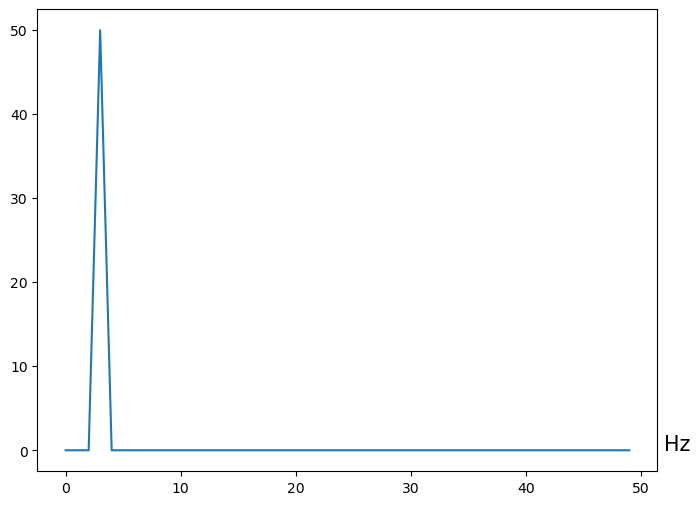

In [19]:
make_plot_freq_1(timeseries,100)

# Adding text to the figure
plt.text(52,0,'Hz',fontsize=15)
plt.show()

### <font color=red>DSP.02.B3.b) Sampling Below the Nyquist frequency</font>

Are you feeling a bit skeptical that that 3 Hz plot really comes from a 97 Hz phenomenon? Let's look at
the same problem in a simpler case. Let's sample a 5 Hz sine wave at 7 Hz. The 7 is above the 5, but the
Nyquist frequency is 7/2 = 3.5, and that's below the 5, so we're claiming that there will be distortion.
Wanna bet? Here is the true 5 Hz sine-wave phenomenon we're about to sample:

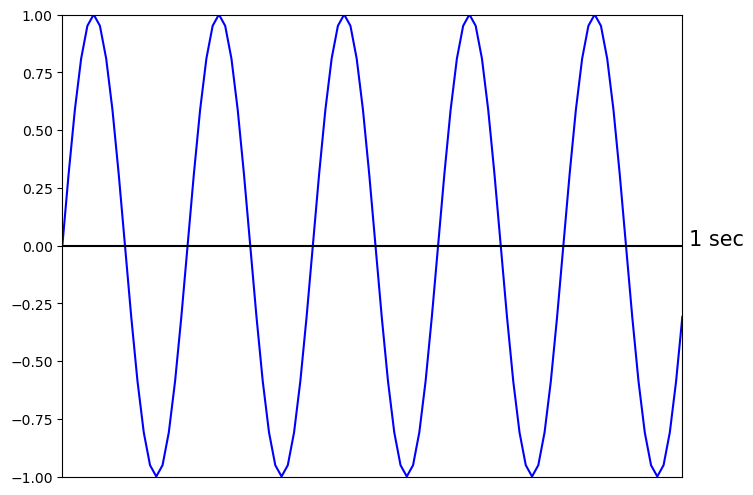

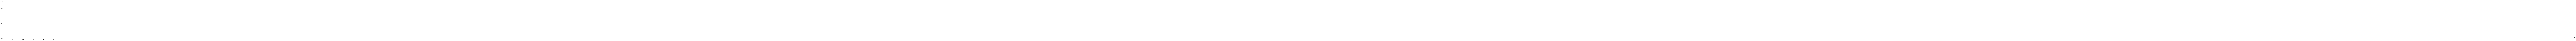

In [20]:
time = np.arange(0,1,0.01)
freq = 5
timeseries = np.sin(2*np.pi * freq * time)

make_plot_1(time,timeseries)
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

# Adding text to the figure
plt.text(52,0,'Hz')
plt.show()

Here is the same 5 Hz signal, with the samples at 7 Hz overlaid in green and the samples connected by straight lines:

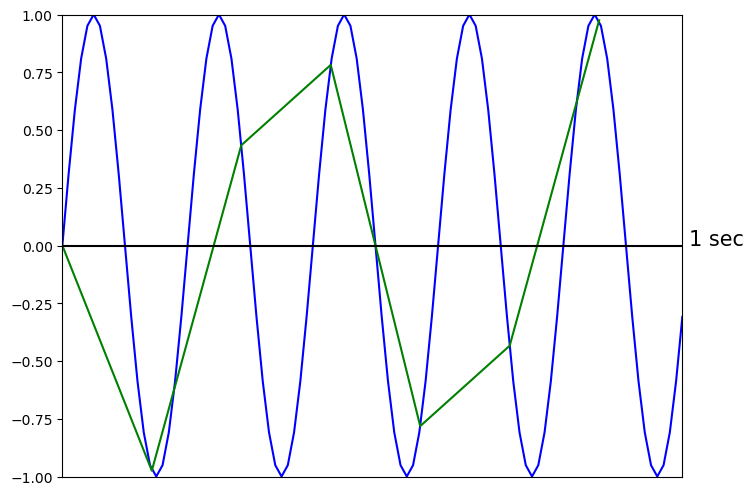

In [21]:
time1 = np.arange(0,1,0.01)
freq1 = 5
timeseries1 = np.sin(2*np.pi * freq1 * time1)

time2 = np.arange(0,1,1/7)
freq2 = 5
timeseries2 = np.sin(2*np.pi * freq2 * time2)

# Plotting time vs amplitude using plot function 
make_plot_2(time1, timeseries1,'blue',time2,timeseries2,'green')

# Adding text to the figure
plt.text(1,0,'1 sec',fontsize=15)

# Finally displaying the plot
plt.show()

You can see that the 7 green sample points (including the first 1 at time 0) fall right on both the (true) 5 Hz sine wave and what appears to be a 2
Hz sine wave. The 5 Hz activity has been aliased to 2 Hz. This is the same problem that happened when
the (true) 97 Hz phenomenon appeared to be a 3 Hz sine wave. (It's just harder to illustrate that,
because the samples are so close together.)

Convinced? Good! The lesson: don't alias = make sure you sample your data faster than twice the
highest frequency in your data. As long as you sample a little faster, you'll represent the original signal accurately. If you want it to be pretty, sample a lot faster.

### <font color=red>DSP.02.B3.c) Rules of thumb</font>

Several caveats can be offered about aliasing.

First, Nyquist's Rule requires sampling at least twice the fastest frequency present in the original waveform -
not merely twice the fastest frequency in which the investigator is interested. (As we noted above, there are two exceptions to
this rule, one of which we'll get to in the next section, the other outside the goals of this e-book. And there's a context in which one can get away with a lower sampling rate, even though it's not a great idea: if the amplitudes of all the frequencies above the Nyquist frequency are really small relative to what you care about. In that case, those higher frequencies will alias down to lower frequencies, but their amplitudes will be so small that you don't mind. That's obviously a judgment call, and we don't recommend considering it.)

Second, treatment of the aliasing problem generally assumes that real-world phenomena are well
represented by sinusoidal components. To the extent the raw data are not perfectly sinusoidal, a
higher sampling frequency is necessary. (If you want to state this more precisely: regardless of how
sinusoidal the phenomenon is, you need to sample more than twice the frequency of the fastest sinewave
frequency that would be needed to model the phenomenon with sine waves, and generally one needs higher-frequency sine waves when modeling non-sinusoidal signals. But don't worry
about that now.)

Third, as shown above, strict conformance to the Nyquist Rule is not necessarily sufficient to provide a
vector of samples that will illustrate the raw data well. A pure sine wave sampled at less than 5 samples
per cycle may look very choppy, and signals composed of multiple components may require a much
higher sample rate in order to provide good visual fidelity. The Nyquist Rule only addresses the aliasing
issue about whether frequencies will be systematically misrepresented. A raw signal composed of sine
waves and sampled at more than twice the frequency of the highest component will not be aliased and
can be treated numerically with confidence, but the vector of samples may not be very presentable
graphically.

There's no simple, satisfactory guideline for how much faster than the Nyquist Frequency one should
sample in order to obtain a nice-looking graph. In the real world, the frequency composition of signals
can be quite complex, can change over time, and can change in the relative and absolute amplitudes of
the various frequency components. You may not even know the highest frequency in the data. There
can also be phase changes over time. Some texts recommend a minimum sample rate 5 to 10 times faster than
the highest frequency in the data. This is a reasonable guideline, but understand that it's just a general
guideline and thus may not suffice in some cases you're working with.

### <font color=red>DSP.02.B3.d) Sampling at exactly twice the Nyquist frequency</font>

Nyquist's Rule requires that we sample at least twice the fastest frequency present in the original
waveform. What happens if we sample at exactly twice the fastest frequency present in the waveform?
The answer isn't obvious and can vary with the circumstance. For that reason alone, in most cases one
should sample well above twice the highest frequency in the data. But there is sometimes an advantage to sampling at exactly the highest frequency in the data, as we shall see.

Take a look. Produce a 10 Hz wave and set the sampling rate to 20 Hz.

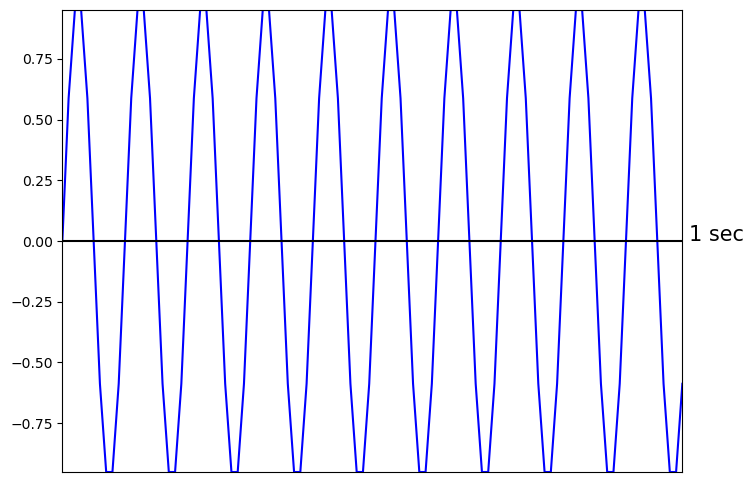

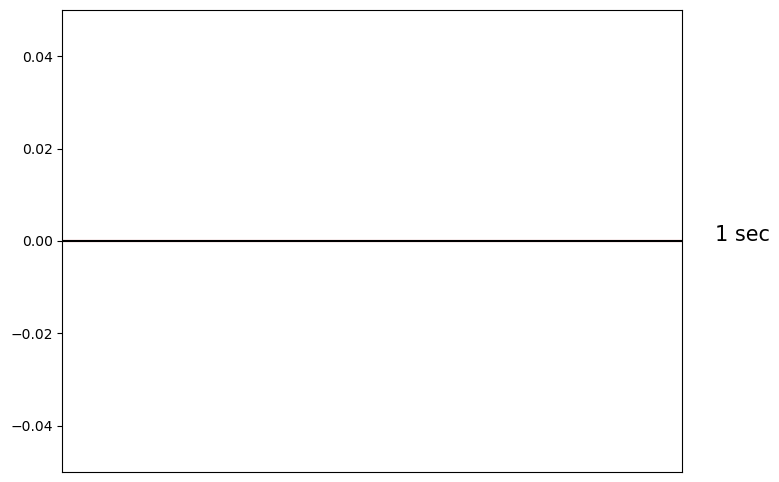

In [22]:
time1 = np.arange(0,1,0.01) 
freq1 = 10
timeseries1 = np.sin(2*np.pi * freq1 * time1)

# Plotting time vs amplitude using plot function 
make_plot_1(time1,timeseries1)
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

time2 = np.arange(0,1,0.05) #collecting 20 samples in a 1 second period
freq2 = 10
timeseries2 = np.round_(np.sin(2*np.pi * freq2 * time2),2)
# Plotting time vs amplitude using plot function from pyplot
make_plot_1(time2,timeseries2,'red')
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

What happened??? The first plot shows our original 10 Hz wave (displayed at a 100 Hz sampling rate). The second plot shows the digitized waveform, sampled at 20 Hz. For our 10 Hz signal, the 100 Hz version (first plot) is well above the Nyquist frequency, and the 20 Hz version (second plot) is right at the Nyquist frequency.
Where is the sine wave in the second plot? What went wrong?

                                                               
Answer:
                                                               
Nothing went wrong, but... When we set our sampling rate at 20 Hz, we recorded a data point every 50 ms = 1000 ms/20. Let's look at that again. Plot where
the data are collected (black dots) and then overlay this plot of the samples on the original 10 Hz timeseries.

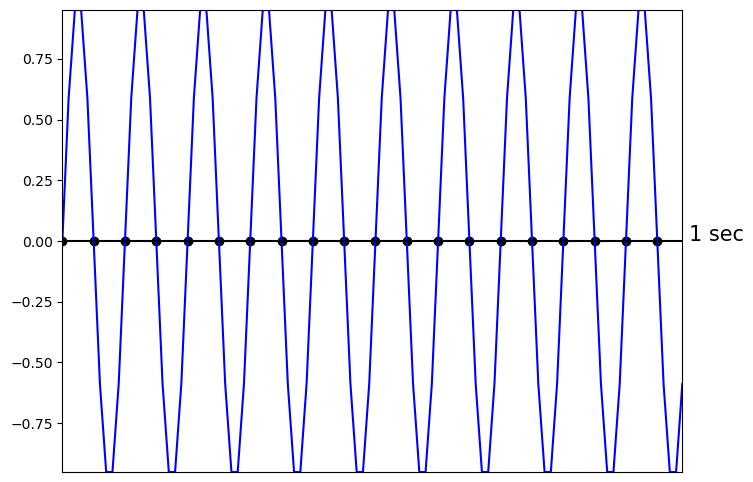

In [23]:
timeseries1 = np.sin(2*np.pi * freq1 * time1)
timeseries2 = np.round_(np.sin(2*np.pi * freq2 * time2),2)

# Plotting time vs amplitude using plot function
make_plot_1(time1,timeseries1)
plt.scatter(time2,timeseries2, color = "k")
plt.text(1,0,'1 sec',fontsize=15)

plt.show()

Every sampled point hits right at zero.

In the above example, when we sampled at exactly twice the fastest frequency in the waveform, we
were perfectly in phase with the signal, starting at phase 0, which has amplitude 0. As a result, we sampled only when the sine wave crossed the x
axis, and the sine wave 'disappeared'. That seems like a very bad idea. Certainly, that is an extremely
serious distortion.

But in some circumstances it's a good idea. If we happen to be interested only in signals with frequencies well below that frequency, but we know that there is activity at that frequency, we can use this
trick to sample the data in a way that is blind to that frequency. For example, say we're interested in 10
Hz activity, but we have 60 Hz noise in what we're measuring. If we digitize at 60 Hz, and if we get the
phase right, we'll represent the 10 Hz activity fairly well and miss the 60 Hz activity completely.

That example isn't hypothetical. In most countries, the standard voltage available at wall sockets is oscillating at 50 or 60 Hz. Every cable in the wall and from a wall socket to our equipment acts as broadcast antenna, sending 50 or 60 Hz noise into our subjects and our recording equipment. As a result, 50 or 60 Hz noise is very common in our measurements. At least in principle, digitizing at that frequency will avoid that noise source.

### <font color=red>DSP.02.B3.e) Sampling at exactly twice the Nyquist frequency - another look</font>

In the example above, we saw that, if we sample at exactly twice the highest frequency in the data, we
'lose' that signal. In the example above the sine wave started at 0. In that case, there was no phase
offset between the signal and the sampling rate. Our first sample was at phase = 0, which had an amplitude of zero, and all subsequent
samples were at zero crossings, too, with amplitudes of zero (phases of 0, 90, 180, 270, and 360 = 0 degrees; i.e., phases of 0𝜋, 𝜋/2, 𝜋, 3𝜋/2, and 2𝜋 = 0𝜋 radians). That's why all our samples had an amplitude of 0. What do you think happens if
a phase offset is introduced? In other words, what happens if we sample the 10 Hz signal at 20 Hz, but
with the phase of the 10 Hz signal not the same as the phase of the 20 Hz signal

Answer:
    
Introduce a 90° phase offset. We do that by adding 𝜋/2 = 'np.pi/2' within the call to the sine function, because 2𝜋 = 360°, so 𝜋/2 radians = 90°.

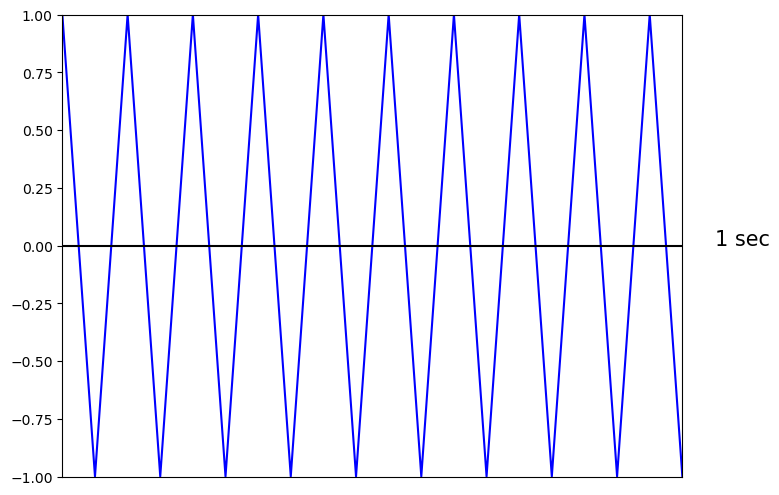

In [24]:
time = np.arange(0,1,0.05) #collecting 20 samples in a 1 second period
freq = 10
timeseries = np.round_(np.sin(2*np.pi * freq * time + np.pi/2),2) # sin(2𝜋 * 10 * time + 𝜋/2)


make_plot_1(time,timeseries)
plt.text(1,0,'1 sec',fontsize=15)

plt.show()

If you count, there are 10 peaks. Since the signal truly was 10 Hz, we are representing the frequency
correctly. 

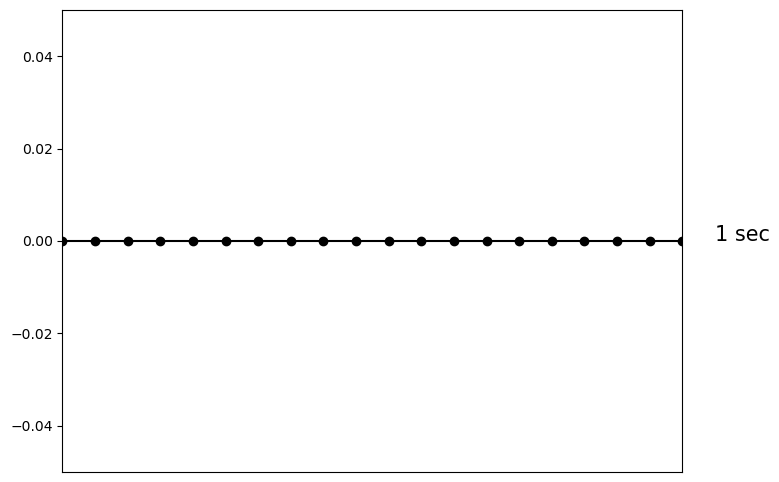

In [25]:
timeseries2 = np.zeros(len(time))
plt.scatter(time, timeseries2, color = "k")
plt.margins(x=0, y=0)
plt.axhline(y=0, color='k')
plt.tick_params(labelbottom = False, bottom = False)

# Adding text to the figure
plt.text(1,0,'1 sec',fontsize=15)

# Finally displaying the plot
plt.show()

Note that this time the plot illustrates only when in time the measurements were taken, not the value (amplitude) of the signal at those times.
That is why the y value is 0 for every point here.

In the first example, we collected samples only when the sine wave hit the x axis. With the phase offset,
we're collecting data at times when the signal amplitude isn't 0.

Now let's plot (a) the black circles on the x-axis showing when we digitize, (b) additional black circles showing the amplitude of the signal we're digitizing at those times, (c) black vertical lines connecting each (a) circle with the corresponding (b) circle (which highlight the amplitude of each sample), and (d) blue lines connecting our digitizing values, which will approximate a continuous sine wave.

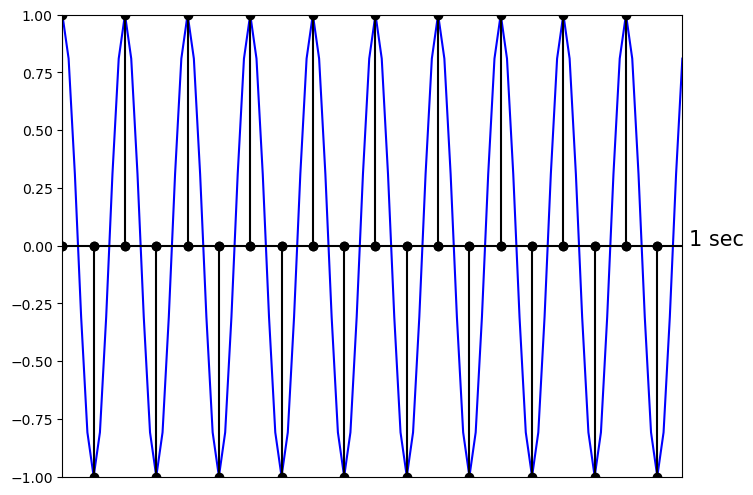

In [26]:
time1 = np.arange(0,1,0.01)
freq1 = 10
timeseries1 = np.sin(2*np.pi * freq * time1 + np.pi/2)

time2 = np.arange(0,1,0.05)
freq2 = 10
timeseries2 = np.round_(np.sin(2*np.pi * freq * time2),2)

# Plotting time vs amplitude using plot function 
make_plot_1(time1,timeseries1)
plt.scatter(time2, timeseries2, color = "k")
for ind in range(len(time2)): 
    x = [time2[ind], time2[ind]]
    y = [timeseries2[ind], timeseries1[(time2[ind]/0.01).astype(int)]]
    plt.plot(x, y, marker = 'o', color='k')

# Adding text to the figure
plt.text(1,0,'1 sec',fontsize=15)

plt.show()

With a 90° phase offset, we hit the high and low peaks. This provides an accurate representation of the
original timeseries.

Look at one more example. Introduce a 45° phase offset (still digitizing at 20 Hz). In the code, we do that by inserting 'np.pi/4' instead of 'np.pi/2'.

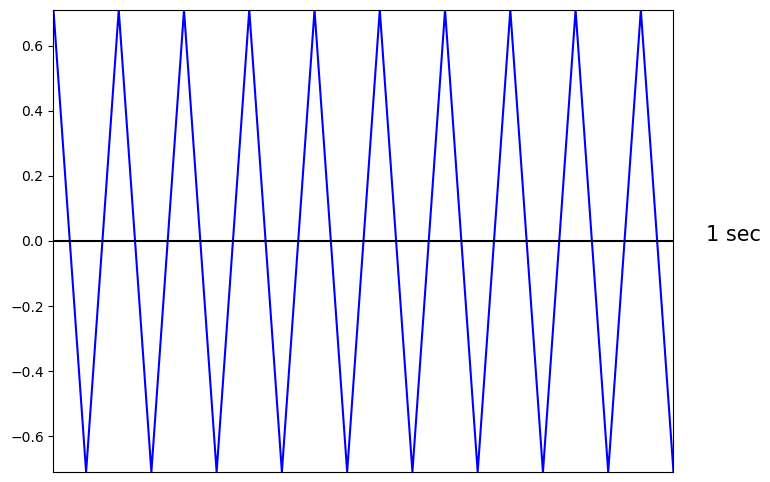

In [27]:
time = np.arange(0,1,0.05)
freq = 10
timeseries = np.round_(np.sin(2*np.pi * freq * time + np.pi/4),2)# 1 * sin(2𝜋 * 10 * time + 𝜋/4)

make_plot_1(time,timeseries)
plt.text(1,0,'1 sec',fontsize=15)

plt.show()

Look where data are collected.

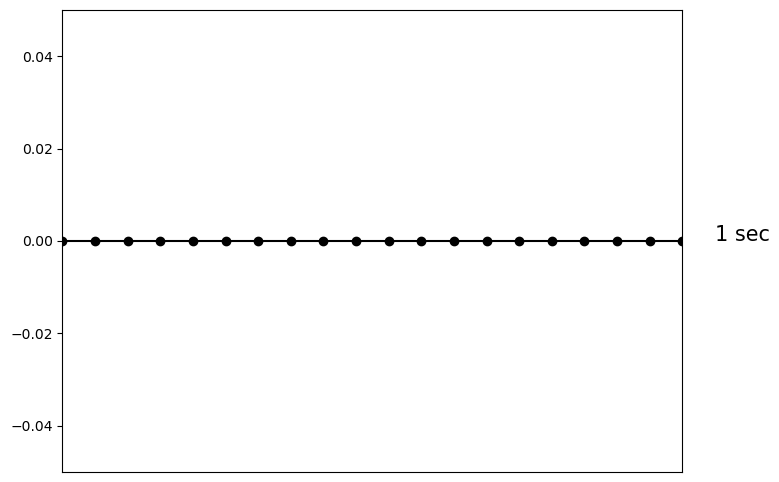

In [28]:
timeseries2 = np.zeros(len(time))
plt.scatter(time, timeseries2, color = "k")
plt.margins(x=0, y=0)
plt.axhline(y=0, color='k')
plt.tick_params(labelbottom = False, bottom = False)

# Adding text to the figure
plt.text(1,0,'1 sec',fontsize=15)

# Finally displaying the plot
plt.show()

In the next plot, we'll see that, with the phase offset, we hit the sine wave at non-zero points and also not at the peak amplitudes.

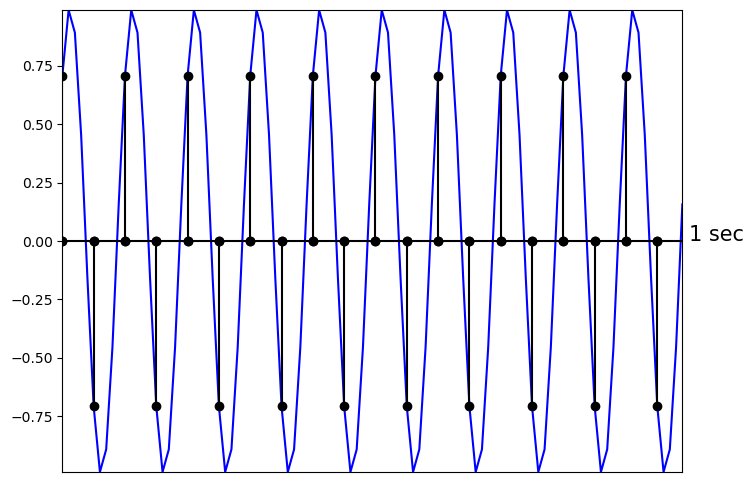

In [29]:
time1 = np.arange(0,1,0.01)
freq1 = 10
timeseries1 = np.sin(2*np.pi * freq * time1 + np.pi/4)

time2 = np.arange(0,1,0.05)
freq2 = 10
timeseries2 = np.round_(np.sin(2*np.pi * freq * time2),2)

# Plotting time vs amplitude using plot function 
make_plot_1(time1,timeseries1)
plt.scatter(time2, timeseries2, color = "k")
for ind in range(len(time2)): 
    x = [time2[ind], time2[ind]]
    y = [timeseries2[ind], timeseries1[(time2[ind]/0.01).astype(int)]]
    plt.plot(x, y, marker = 'o', color='k')

# Adding text to the figure
plt.text(1,0,'1 sec',fontsize=15)
plt.show()

If we started with those black circles on the blue lines and simply connected them, without the blue lines, we'd have what appears to be a smaller 10 Hz signal. But because we ‘hit’ each cycle at least twice, this provides an accurate representation of the frequency in the original
timeseries. The full amplitude won't be preserved unless you happen to sample right at the peak of each cycle.

### <font color=red>DSP.02.B3.f) One more than twice the Nyquist frequency</font>

Sampling at exactly twice the Nyquist frequency doesn't look like a good idea in almost any situation. Although we don't end
up with an aliased frequency, we could get a wide range of amplitudes for our (valid) frequency, so we
are distorting the amplitude of that frequency, usually in an unpredictable way. In fact, at zero phase
difference between signal and sampling, which produces zero amplitudes, we have essentially aliased
down to 0 Hz, with nothing of the original amplitude preserved. In the real world, we often don't know if we are in or out of phase with phenomenon we're sampling. And as we noted earlier, the phase of a signal can change over time.

How about if we sample slightly above twice the Nyquist frequency.

Here is a 10 Hz wave sampled at 21 Hz.

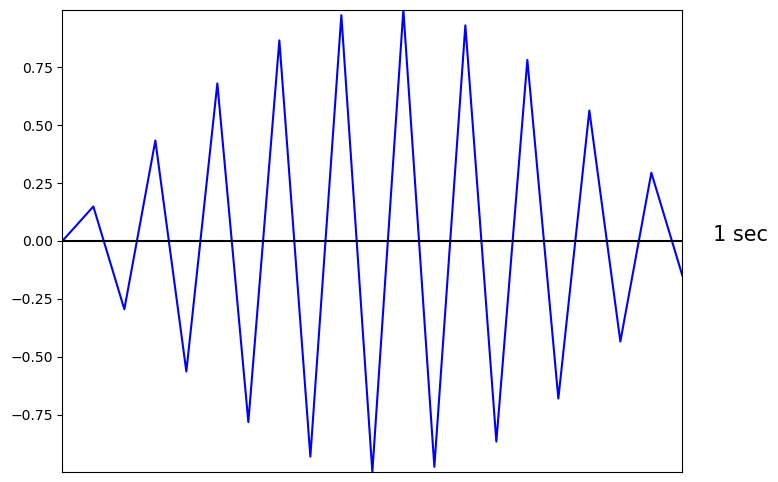

In [30]:
time = np.arange(0,1,1/21) #collecting 21 samples in a 1 second period
freq = 10
timeseries = np.sin(2*np.pi * freq * time)

make_plot_1(time,timeseries)
plt.text(1,0,'1 sec',fontsize=15)

plt.show()

It's not visually pleasing, but count and you'll see that there are 10 peaks. Look at where the data points are collected.

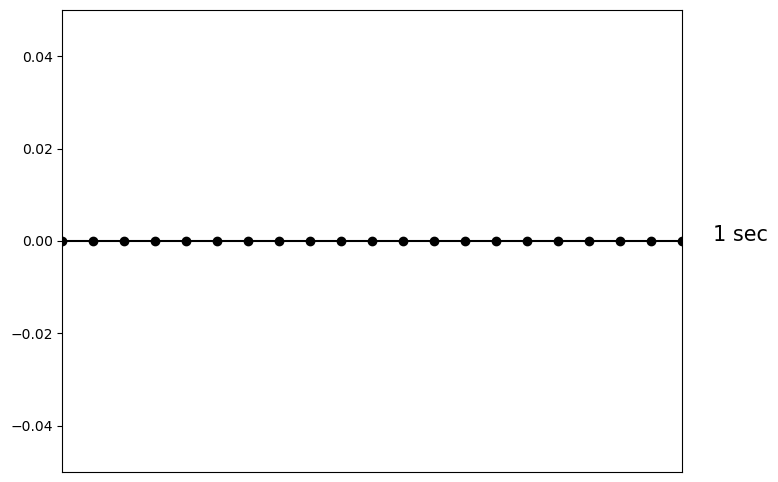

In [31]:
timeseries2 = np.zeros(len(time))
plt.scatter(time, timeseries2, color = "k")
plt.margins(x=0, y=0)
plt.axhline(y=0, color='k')
plt.tick_params(labelbottom = False, bottom = False)

# Adding text to the figure
plt.text(1,0,'1 sec',fontsize=15)

# Finally displaying the plot
plt.show()

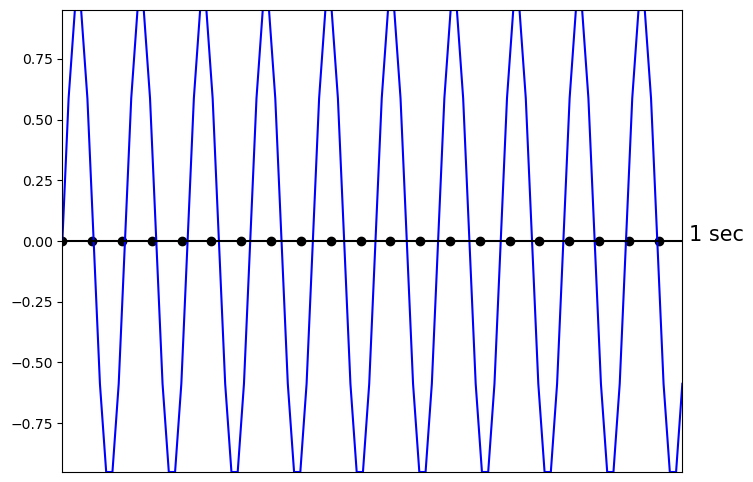

In [32]:
time1 = np.arange(0,1,0.01)
freq = 10
timeseries1 = np.sin(2*np.pi * freq * time1)

time2 = np.arange(0,1, 1/21)
timeseries2 =  np.zeros(len(time2))

# Plotting time vs amplitude using plot function 
make_plot_1(time1,timeseries1)
plt.scatter(time2, timeseries2, color = "k")

# Adding text to the figure
plt.text(1,0,'1 sec',fontsize=15)

plt.show()

One point higher than the Nyquist frequency is enough so that we have (ever so slightly more than) two
samples for each complete cycle (i.e., each period). Plot the frequency spectrum to confirm that 21 Hz
sampling is enough to do the job - to represent the 10 Hz signal, including its amplitude.

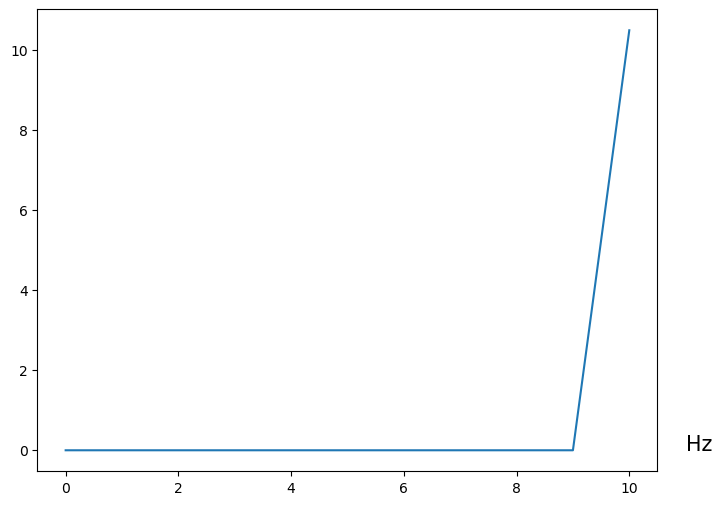

In [33]:
timeseries = np.sin(2*np.pi * freq * time2)
make_plot_freq_1(timeseries,21)

# Adding text to the figure
plt.text(11,0,'Hz',fontsize=15)
plt.show()

It is not a great plot, but there is definitely a peak at 10 Hz. (In later lessons we'll see why the plot ends
at around 10 Hz.)

### <font color=red>DSP.02.B3.g) An instance where sampling at exactly the Nyquist frequency is useful</font>

We saw that, if we sample at exactly twice the highest frequency, we sometimes 'lose' that frequency.
As previously noted, sometimes we can use this to our advantage.

The following timeseries shows data (collected at 150 Hz) that contain real activity at 10 Hz as well as a noise
signal at 60 Hz that dominates the recording. It's a type of noise typically found in electrical recordings - 60 Hz
noise is typical in the Americas, 50 Hz in Europe and Africa; Japan has a mix of 50 and 60 Hz circuits, depending on region. This is a function of typical 
electrical circuits in buildings.

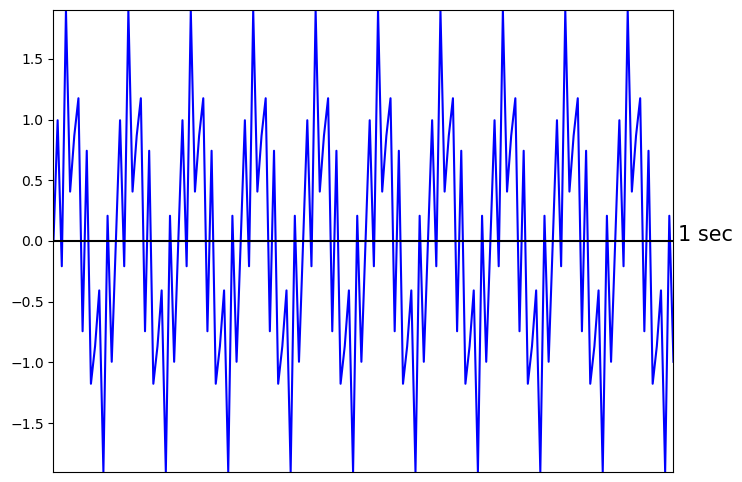

In [34]:
time = np.arange(0,1,1/150)
timeseries = np.sin(2*np.pi * 10 * time) + np.sin(2*np.pi * 60 * time)

# Plotting time vs amplitude using plot function 
make_plot_1(time,timeseries)
plt.text(1,0,'1 sec',fontsize=15)

plt.show()

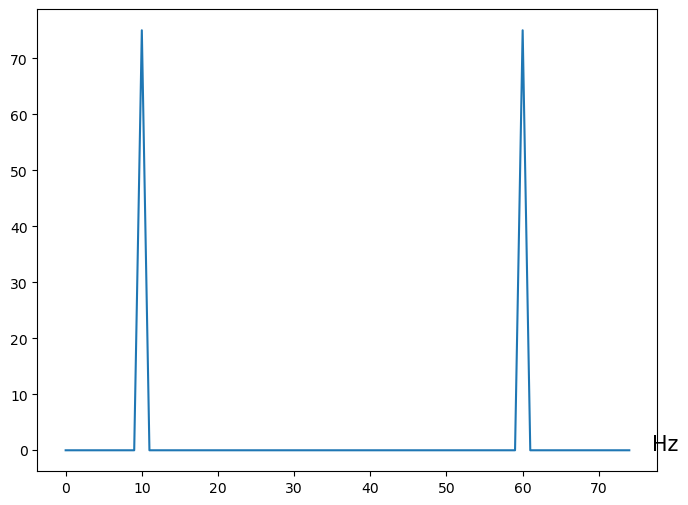

In [35]:
make_plot_freq_1(timeseries,150)

# Adding text to the figure
plt.text(77,0,'Hz',fontsize=15)
plt.show()

If you knew in advance that you had to deal with 60 Hz noise, and if the highest frequency of interest
was 10 Hz, how could you remove the 60 Hz noise?

Answer:

Easy. As long as you are in phase with the 60 Hz activity, just sample at exactly twice the 60 Hz activity.

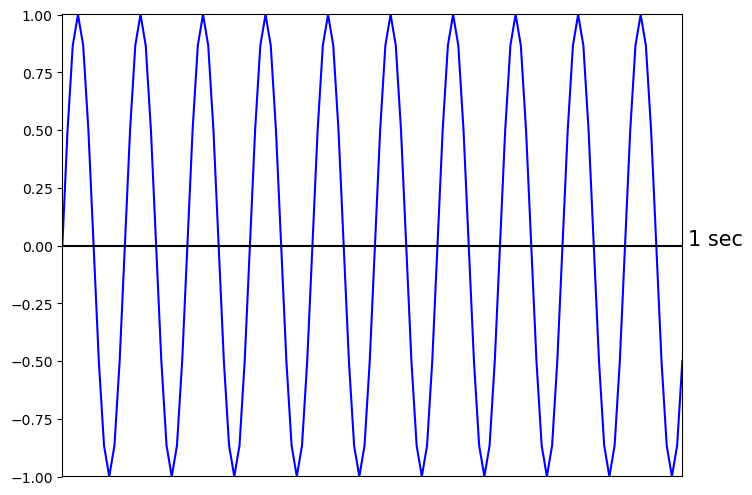

In [36]:
time = np.arange(0,1,1/120)
timeseries = np.sin(2*np.pi *10 * time) + np.sin(2*np.pi *60 * time)

# Plotting time vs amplitude using plot function 
make_plot_1(time,timeseries)
plt.text(1,0,'1 sec',fontsize=15)

plt.show()

The second plot looks pretty clean. Just to confirm, plot the frequency spectrum.

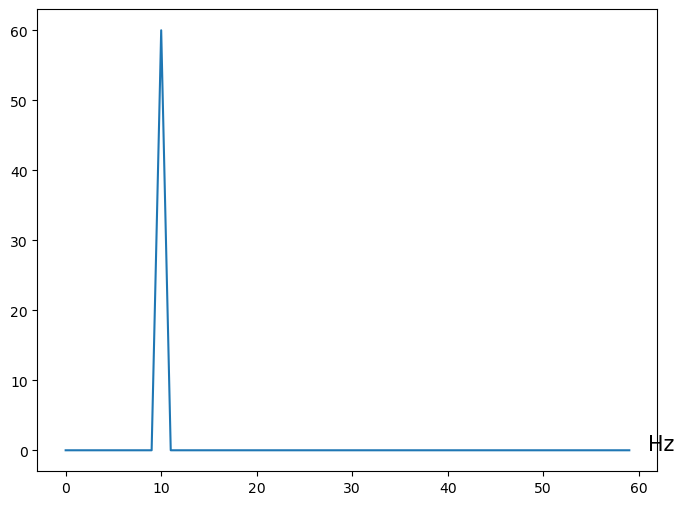

In [37]:
make_plot_freq_1(timeseries,120)

# Adding text to the figure
plt.text(61,0,'Hz',fontsize=15)
plt.show()

Smooth sailing. The original data has both 10 Hz signal and 60 Hz noise. We chose a sampling rate that did a fine job capturing 10 Hz and couldn't see 60 Hz. The moral of the story: the more information you have about the signal and noise properties of the phenomenon you're going to digitize, the better you can design your data acquistion.

### <font color=red>DSP.02.B3.g.i) </font>

Let's push this trick: would sampling at a higher multiple of 60 Hz (a harmonic) remove the 60 Hz noise?

Let's see. Try sampling at 180 Hz (3 × 60 Hz).

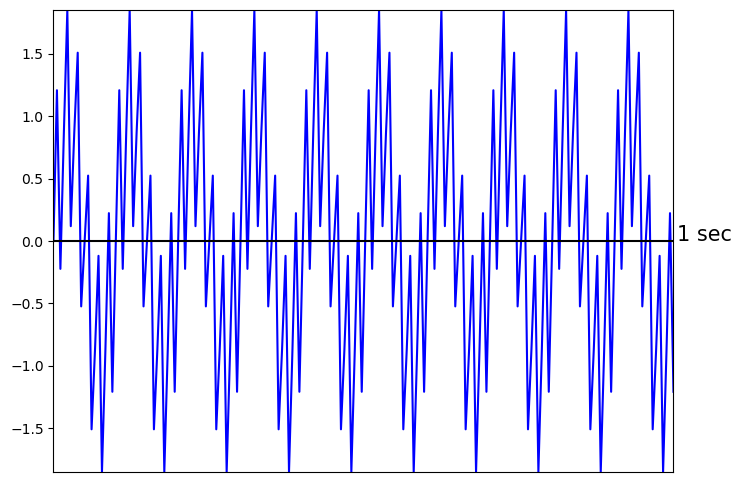

In [38]:
time = np.arange(0,1,1/180)
timeseries = np.sin(2*np.pi * 10 * time) + np.sin(2*np.pi *60 * time)

# Plotting time vs amplitude using plot function 
make_plot_1(time,timeseries)
plt.text(1,0,'1 sec',fontsize=15)

plt.show()

Doesn't look promising. Plot the frequency spectrum.

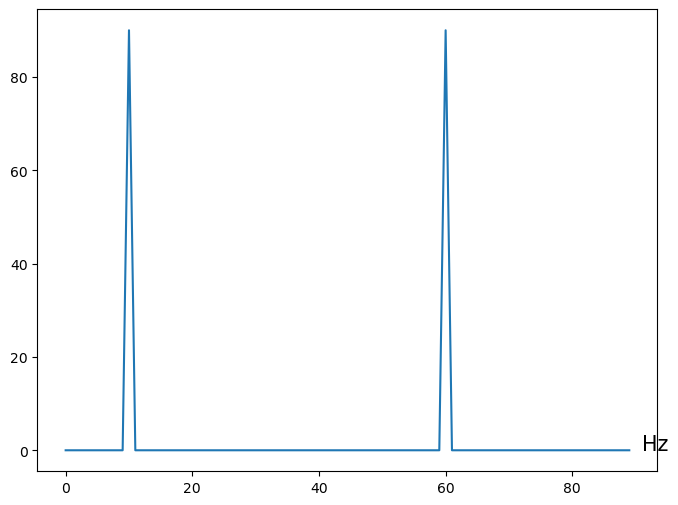

In [39]:
make_plot_freq_1(timeseries,180)

# Adding text to the figure
plt.text(91,0,'Hz',fontsize=15)
plt.show()

Nope, 60 Hz activity remains. This makes sense - we can only hit the zero line exactly once, and this
happens only when we sample at exactly twice a particular frequency.

Stepping back from trying to game the 60 Hz noise, notice that the 180 Hz sampling rate gives us a Nyquist frequency of 90 Hz, which is higher than 60 Hz. So, sampling at 180 Hz is going to do a good job of representing the 60 Hz activity (whether you want it or not).

### <font color=red>DSP.02.B3.g.ii) </font>

OK, that didn't work. What if we go the other way: would sampling at a submultiple of 60 Hz (30 Hz, 15 Hz, 12 Hz, etc.) avoid
the 60 Hz noise?

Answer:
    
Let's see. Try sampling at 30 Hz ( 1/2 × 60 Hz).

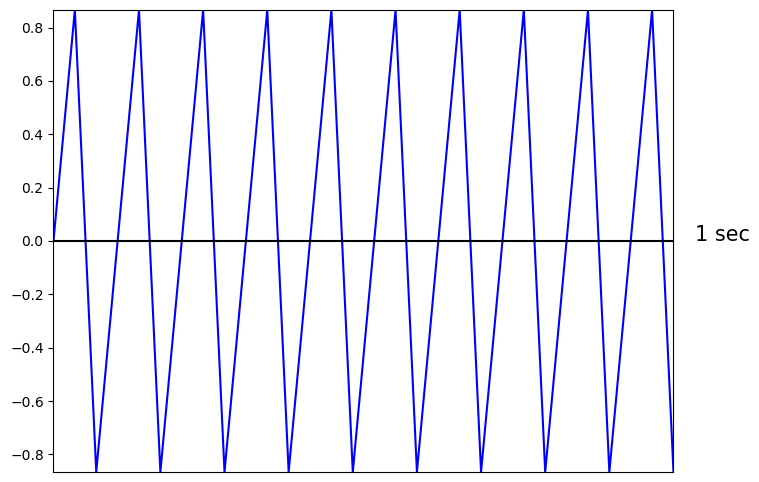

In [40]:
time = np.arange(0,1,1/30)
timeseries = np.sin(2*np.pi * 10 * time) + np.sin(2*np.pi *60 * time)

# Plotting time vs amplitude using plot function 
make_plot_1(time,timeseries)
plt.text(1,0,'1 sec',fontsize=15)

plt.show()

Looks like there are 10 positive peaks, and it looks like the noise is gone. Plot the frequency spectrum.

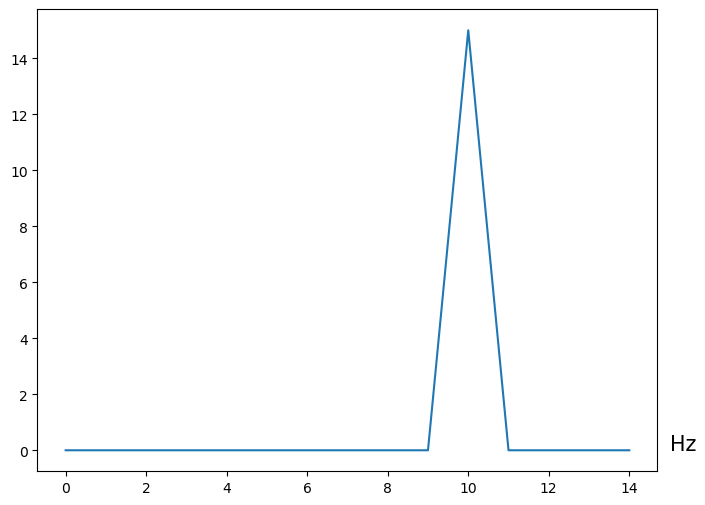

In [41]:
make_plot_freq_1(timeseries,30)

# Adding text to the figure
plt.text(15,0,'Hz',fontsize=15)
plt.show()

Looks good. We get a single peak at 10 Hz. This makes sense. When we sample at a lower multiple,
we might not hit every place where 60 Hz noise crosses the x axis, but when the 60 Hz wave is
sampled, it is sampled only at moments when its amplitude is zero. So, it disappears.

### <font color=red>DSP.02.B3.h (The other half) </font>

We started by asking how often we need to sample to accurately represent a timeseries. We noted that
the Nyquist-Shannon sampling theorem provides half the answer. And here is the other half.....

It depends on the data you are collecting. You need to digitize at more than twice the highest frequency
that occurs in the measured activity (not just the highest frequency you are interested in examining).
Because of possible errors in estimating the highest frequencies in real-world data, noise introduced
by amplifiers and A/D converters (and that noise may have some high-frequency components), and the nonsinusoidal nature of many real world events, it has
long been suggested that the sample rate be as much as 5-10x higher than the Nyquist rule suggests.

On the other hand, when it is believed that the noise power introduced at high frequencies is minimal,
less intensive sampling may suffice, and the resulting (trivially small) aliased noise ignored. As we saw
above, a second situation in which the Nyquist rule can sometimes be violated is where all high-frequency
noise sources are a harmonic of a single frequency. With the right sampling period and perhaps
the right choice of phase, the sampling will occur at the same phase of the noise cycle with every
sample (e.g., power-line noise at 50 or 60 Hz). However, if you don't get the phase right, the obtained
samples may include a DC offset (meaning a constant, nonzero voltage level) that can vary by as much as the full peak-to-peak range of the noise,
which may or may not be problematic in a given context.

## <font color=red>DSP.02.B4) Multiplying Sine Waves</font>

### <font color=red>DSP.02.B4.a) Multiplying Sine Waves to Creating a Timeseries</font>

Check out this function.

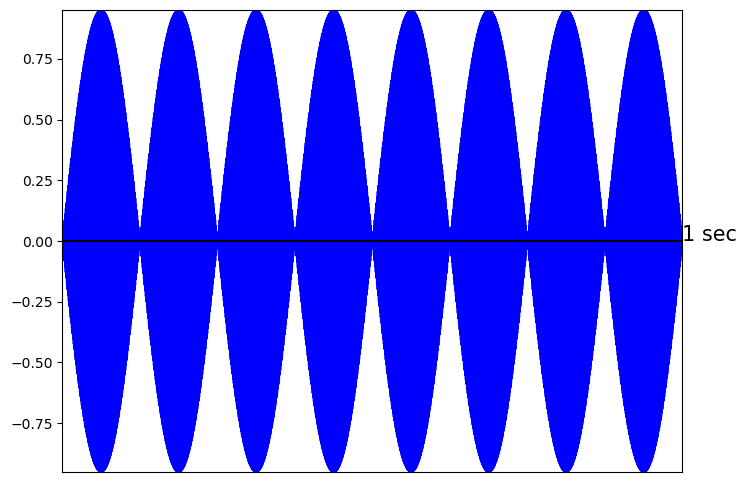

In [42]:
time = np.arange(0,1,1/5000)
freq1 = 4
freq2 = 2000
timeseries = np.sin(2*np.pi *freq1 * time) * np.sin(2*np.pi *freq2 * time)

# Plotting time vs amplitude using plot function 
make_plot_1(time,timeseries)
plt.text(1,0,'1 sec',fontsize=15)

plt.show()

Instead of adding timeseries, the above timeseries was created by multiplying two sine waves of
different frequencies - 4 Hz and 2000 Hz. Amplitude (their product) is plotted on the y axis and time on
the x axis.

Although the formula sin[2000x×2π] × sin[4x×2π] looks slightly unwieldy, what we have already
learned provides the information needed to understand something about this timeseries.
Take another look at this timeseries.

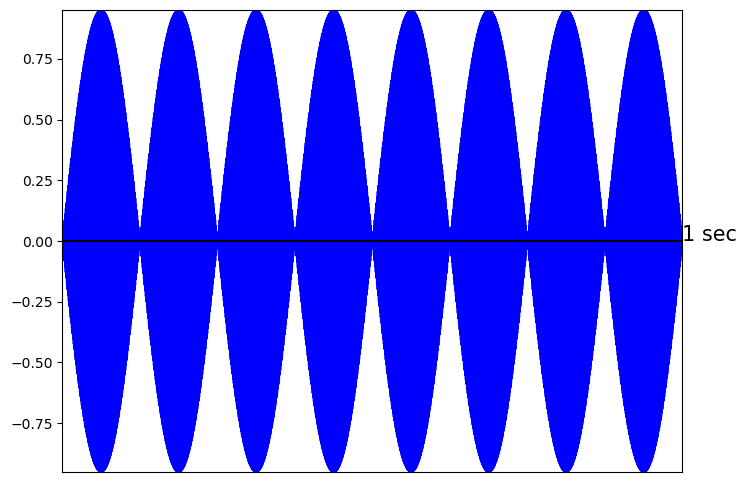

In [43]:
# Plotting time vs amplitude 
make_plot_1(time,timeseries)
plt.text(1,0,'1 sec',fontsize=15)

plt.show()

Instead of an obvious 4 Hz signal, there appear to be 8 distinct 'pulses'. Why are there eight distinct pulses?

The formula f[x] = Sin[4x×2π] * Sin[2000x×2π] creates a timeseries from a 4 Hz and 2000 Hz sine wave. 

The lowest frequency is 4 Hz.

Plot the same timeseries, this time overlaying a 4 Hz sine wave.

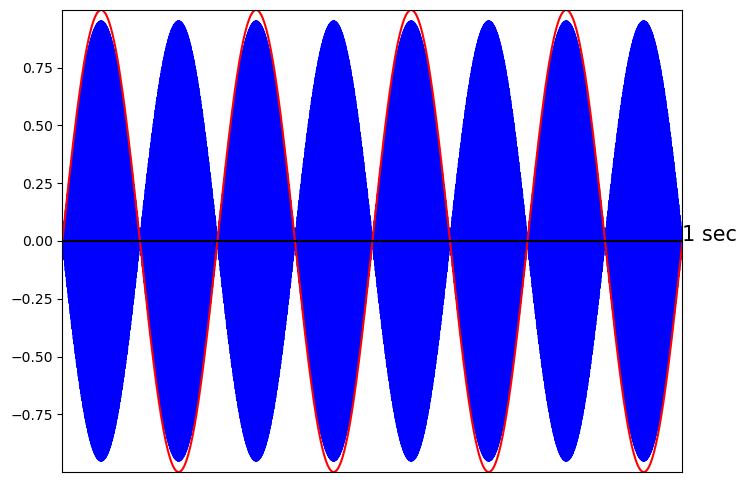

In [44]:
timeseries2 = np.sin(2*np.pi *freq1 * time)

# Plotting time vs amplitude 
make_plot_2(time,timeseries,'blue', time, timeseries2,'red')
plt.text(1,0,'1 sec',fontsize=15)

plt.show()

The high and low points of the timeseries are bounded by the 4 Hz sine wave. In addition, although at
each time point the lines are symmetric about the x axis, the general form of the timeseries seems to be determined by the 4 Hz sine wave. One might say that the general features of this timeseries are determined
by the lowest frequency.

Although we'll save the details of why this has to happen for a later lesson, there is a simple way to get
a feel for what is happening.

Plot the 4 Hz and 2000 Hz sine wave on the same plot.

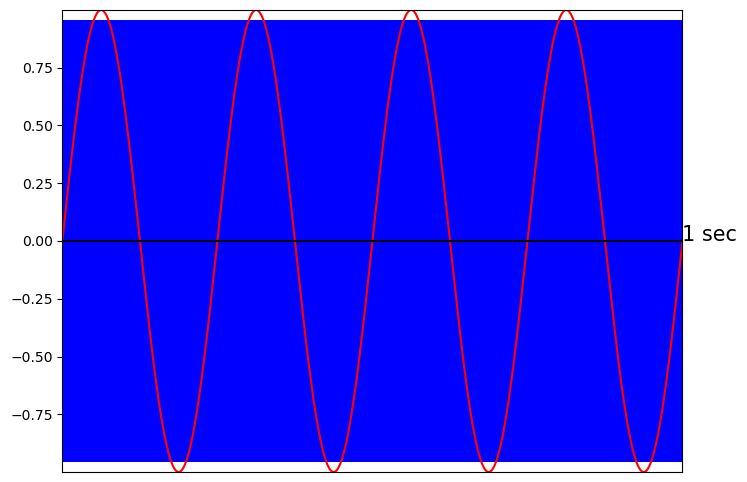

In [45]:
timeseries1 = np.sin(2*np.pi *freq1 * time) 
timeseries2 = np.sin(2*np.pi *freq2 * time)

# Plotting time vs amplitude 
make_plot_2(time,timeseries2,'blue', time, timeseries1,'red')
plt.text(1,0,'1 sec',fontsize=15)

plt.show()

The 4 Hz sine wave is shown in red. The 2000 Hz sine wave in blue. (The peaks of the 2000 Hz sine wave
may look at little choppy or uneven, depending on your screen resolution. That is actually a manifestation
of aliasing in the distance or space domain, but we won't go into that here. The numbers we're
working with here don't have that choppiness. By the way, if you're a computer gamer, you've probably run across the term 'aliasing' regarding game displays. That's the same aliasing we discussed above.)
                                                                    
When the 4 Hz sine wave is at a high (+1) or low (-1) value, the 4 Hz sine wave at that value is multiplied
with the 2000 Hz sine value at that same time point. Depending on the value of the 2000 Hz sine wave at
that point, there is a chance of obtaining a large or small value (+1 × the 2000 Hz value at that same
time point, or -1 × the 2000 Hz value at that same time point). Thus, the 4 Hz sine wave determines the
general structure of the combined function, because the 4 Hz wave determines when function values
(the product of the 2 sine waves) are large and when function values are small. One way to think of
what happens when you multiply 2 sine waves is that 1 of the sine waves modulates the other.

More on that notion of modulation later. Note that it's crucial in some types of communication - whether radio/TV/cell-phone signals or neural connectivity.

### <font color=red>DSP.02.B4.b) Multiplying Sine Waves and the Nyquist Criterion</font>

Create a timeseries by multiplying a 20 Hz sine wave and 2000 Hz sine wave, digitized at 5000 Hz.

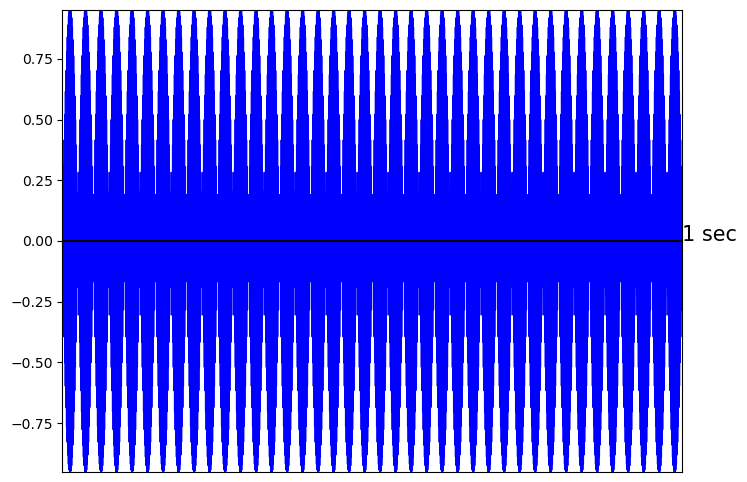

In [46]:
time = np.arange(0,1,1/5000)
freq1 = 20
freq2 = 2000
timeseries = np.sin(2*np.pi *freq1 * time) * np.sin(2*np.pi *freq2 * time)

# Plotting time vs amplitude 
make_plot_1(time,timeseries)
plt.text(1,0,'1 sec',fontsize=15)

plt.show()

We created the above timeseries by multiplying two sine waves at different frequencies - 20 Hz and
2000 Hz. One way to describe this is to say that we're modulating the 2000 Hz signal at 20 Hz - more on
this in a moment.

To correctly represent this timeseries, what is the lowest digitization rate you could use? Is the 5000 Hz sampling rate sufficient?

Answer:

Multiplying sine waves is not the same as adding sine waves. In particular, multiplying two sine waves
yields oscillatory activity at 2 new frequencies: at the sum and difference of the two sine waves. In the example above, we
multiplied 20 Hz and 2000 Hz sine waves. The sum of the two sine waves is 2020 Hz, and the difference
is 1980 Hz.

Thus, we need to sample at (or preferably above) 4040 Hz to accurately represent the timeseries that resulted from the multiplication.
Let's sample at 5000 Hz and look at the power spectrum.

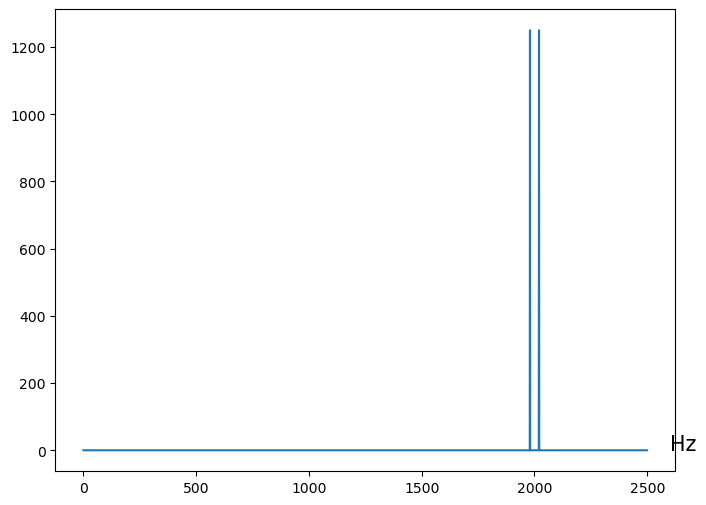

In [47]:
make_plot_freq_1(timeseries,5000)

# Adding text to the figure
plt.text(2600,0,'Hz',fontsize=15)
plt.show()

Looks good. Just what we expected. A peak at 1980 Hz and another peak at 2020 Hz. 

### <font color=red>DSP.02.B4.c) One Last Look at Multiplying Sine Waves</font>

Let's look at multiplying sine waves a little more closely.

Consider a case that is easier to examine visually.

Multiply a 10 Hz and 5 Hz sine wave.

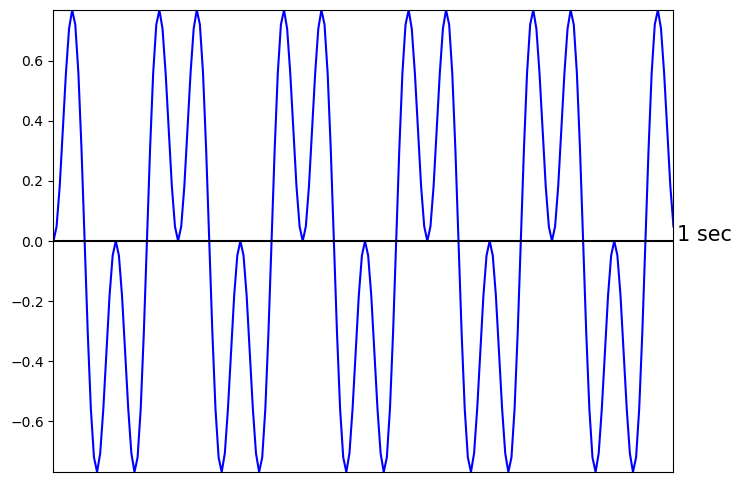

In [48]:
time = np.arange(0,1,0.005)
freq1 = 10
freq2 = 5
timeseries = np.sin(2*np.pi *freq1 * time) * np.sin(2*np.pi *freq2 * time)

# Plotting time vs amplitude using plot function 
make_plot_1(time,timeseries)
plt.text(1,0,'1 sec',fontsize=15)

plt.show()

Take a look at the power spectrum.

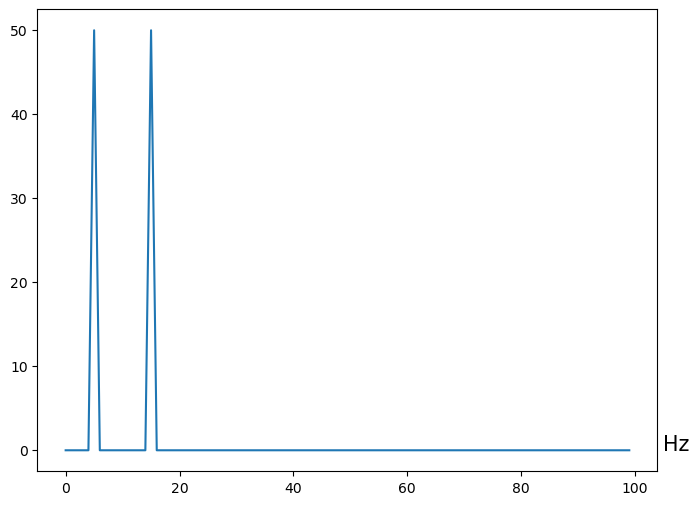

In [49]:
make_plot_freq_1(timeseries,200)

# Adding text to the figure
plt.text(105,0,'Hz',fontsize=15)
plt.show()

Just what we should expect. Two peaks at the sum and difference of the 5 and 10 Hz sine waves - a
peak at 5 Hz and a peak at 15 Hz.

Multiplying a sine wave by another sine wave produces what is called 'balanced modulation'.